In [1]:
import time
import logging
from IPython.display import Audio

from IDRnD.utils import *
from IDRnD.augmentations import *
from IDRnD.dataset import *
from IDRnD.resnet import *
from IDRnD.nasnet_mobile import NASNetAMobile
from IDRnD.focalloss import FocalLoss
from IDRnD.callbacks import *
from IDRnD.pipeline import *

import numpy as np
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from sklearn.model_selection import StratifiedKFold, train_test_split

%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed_everything(0)
logging.basicConfig(level=logging.DEBUG, filename="logs/logs.log",
                    filemode="w+")

In [3]:
post_transform = transforms.Compose([
    librosa.power_to_db,
    PadOrClip(320),
    Normalize_predef(-29.6179, 16.6342),
    ToTensor(),
])

In [ ]:
batch_size = 435
thresh = 0.001

criterion = nn.BCELoss().cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)
model = resnet34(num_classes=1).cuda()

tb_logger = TensorBoardCallback(compute_eer)
saver = SaveEveryEpoch("models/resnet_34_finding_best_val.pt")
best = SaveBestEpoch("models/resnet_34_finding_best_val.pt", compute_eer)
hm = Train(callbacks=[tb_logger, saver, best])

In [ ]:
##first loop

In [2]:
X, y = get_train_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

'mask = np.load("IDRnD/data/mask.npy")\nX_good, X_bad, y_good, y_bad = X_val[np.invert(mask)], X_val[mask], y_val[np.invert(mask)], y_val[mask]\nX_train_new, y_train_new = np.concatenate((X_train, X_bad)), np.concatenate((y_train, y_bad))\nX_val_new, y_val_new = X_good, y_good\n\nX, y = np.concatenate((X_train_new, common_X, pathes_old_competition)), np.concatenate((y_train_new, common_y, classes_old_competition))'

In [5]:
train_dataset = SimpleMelDataset(X_train, y_train, "../data/files/raw_mels/", post_transform)
valid_dataset = SimpleMelDataset(X_val, y_val, "../data/files/raw_mels/", post_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size*3, num_workers=16, shuffle=False)

state = torch.load("models/resnet34-333f7ec4.pth")#'models/resnet34-333f7ec4.pth')
state.pop("conv1.weight")
state.pop("fc.weight")
state.pop("fc.bias")
model.load_state_dict(state, strict=False)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)
hm.fit(train_loader, valid_loader, model_dst, criterion, optimizer, epoches=10)

In [9]:
state = torch.load("models/resnet_34_finding_best_val.pt4")
model.load_state_dict(state, strict=True)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
preds = hm.predict_on_test(valid_loader, model_dst)

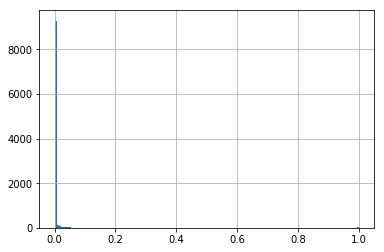

In [10]:
index = preds.index.tolist()
indexes = [int(idx) for idx in index]
preds["abs_diff"] = np.abs(preds[0] - indexes)
preds["abs_diff"].hist(bins=150)

In [17]:
preds['names'] = X_val
del_from_validation = set(np.array(preds["names"][preds["abs_diff"] < thresh]))
mask = np.array([True if item in del_from_validation else False for item in X_val])
X_good, X_bad, y_good, y_bad = X_val[np.invert(mask)], X_val[mask], y_val[np.invert(mask)], y_val[mask]
X_train_new, y_train_new = np.concatenate((X_train, X_bad)), np.concatenate((y_train, y_bad))
X_white_list, y_white_list = X_good, y_good

In [ ]:
##second_loop

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=42, stratify=y_train_new)
X_val, y_val = np.concatenate((X_val, X_white_list)), np.concatenate((y_val, y_white_list))

In [22]:
train_dataset = SimpleMelDataset(X_train, y_train, "../data/files/raw_mels/", post_transform)
valid_dataset = SimpleMelDataset(X_val, y_val, "../data/files/raw_mels/", post_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size*3, num_workers=16, shuffle=False)

state = torch.load("models/resnet34-333f7ec4.pth")#'models/resnet34-333f7ec4.pth')
state.pop("conv1.weight")
state.pop("fc.weight")
state.pop("fc.bias")
model.load_state_dict(state, strict=False)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)

tb_logger = TensorBoardCallback(compute_eer)
saver = SaveEveryEpoch("models/resnet_34_finding_best_val.pt")
best = SaveBestEpoch("models/resnet_34_finding_best_val.pt", compute_eer)
hm = Train(callbacks=[tb_logger, saver, best])

hm.fit(train_loader, valid_loader, model_dst, criterion, optimizer, epoches=10)

In [23]:
state = torch.load("models/resnet_34_finding_best_val.pt4")
model.load_state_dict(state, strict=True)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
preds = hm.predict_on_test(valid_loader, model_dst)

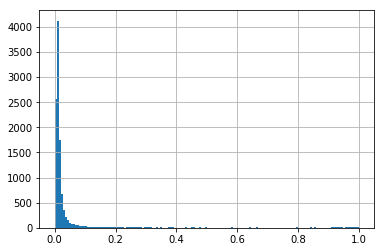

In [24]:
index = preds.index.tolist()
indexes = [int(idx) for idx in index]
preds["abs_diff"] = np.abs(preds[0] - indexes)
preds["abs_diff"].hist(bins=150)

In [25]:
preds['names'] = X_val
del_from_validation = set(np.array(preds["names"][preds["abs_diff"] < thresh]))
mask = np.array([True if item in del_from_validation else False for item in X_val])
X_good, X_bad, y_good, y_bad = X_val[np.invert(mask)], X_val[mask], y_val[np.invert(mask)], y_val[mask]
X_train_new, y_train_new = np.concatenate((X_train, X_bad)), np.concatenate((y_train, y_bad))
X_white_list, y_white_list = X_good, y_good

In [29]:
##third loop

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=42, stratify=y_train_new)
X_val, y_val = np.concatenate((X_val, X_white_list)), np.concatenate((y_val, y_white_list))

In [31]:
train_dataset = SimpleMelDataset(X_train, y_train, "../data/files/raw_mels/", post_transform)
valid_dataset = SimpleMelDataset(X_val, y_val, "../data/files/raw_mels/", post_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size*3, num_workers=16, shuffle=False)

state = torch.load("models/resnet34-333f7ec4.pth")#'models/resnet34-333f7ec4.pth')
state.pop("conv1.weight")
state.pop("fc.weight")
state.pop("fc.bias")
model.load_state_dict(state, strict=False)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)

tb_logger = TensorBoardCallback(compute_eer)
saver = SaveEveryEpoch("models/resnet_34_finding_best_val.pt")
best = SaveBestEpoch("models/resnet_34_finding_best_val.pt", compute_eer)
hm = Train(callbacks=[tb_logger, saver, best])

hm.fit(train_loader, valid_loader, model_dst, criterion, optimizer, epoches=10)

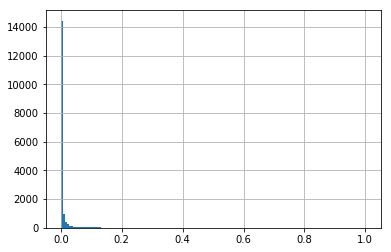

In [32]:
state = torch.load("models/resnet_34_finding_best_val.pt1")
model.load_state_dict(state, strict=True)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
preds = hm.predict_on_test(valid_loader, model_dst)

index = preds.index.tolist()
indexes = [int(idx) for idx in index]
preds["abs_diff"] = np.abs(preds[0] - indexes)
preds["abs_diff"].hist(bins=150)

In [33]:
preds['names'] = X_val
del_from_validation = set(np.array(preds["names"][preds["abs_diff"] < thresh]))
mask = np.array([True if item in del_from_validation else False for item in X_val])
X_good, X_bad, y_good, y_bad = X_val[np.invert(mask)], X_val[mask], y_val[np.invert(mask)], y_val[mask]
X_train_new, y_train_new = np.concatenate((X_train, X_bad)), np.concatenate((y_train, y_bad))
X_white_list, y_white_list = X_good, y_good

In [36]:
#forth

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=42, stratify=y_train_new)
X_val, y_val = np.concatenate((X_val, X_white_list)), np.concatenate((y_val, y_white_list))

In [38]:
train_dataset = SimpleMelDataset(X_train, y_train, "../data/files/raw_mels/", post_transform)
valid_dataset = SimpleMelDataset(X_val, y_val, "../data/files/raw_mels/", post_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size*3, num_workers=16, shuffle=False)

state = torch.load("models/resnet34-333f7ec4.pth")#'models/resnet34-333f7ec4.pth')
state.pop("conv1.weight")
state.pop("fc.weight")
state.pop("fc.bias")
model.load_state_dict(state, strict=False)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)

tb_logger = TensorBoardCallback(compute_eer)
saver = SaveEveryEpoch("models/resnet_34_finding_best_val.pt")
best = SaveBestEpoch("models/resnet_34_finding_best_val.pt", compute_eer)
hm = Train(callbacks=[tb_logger, saver, best])

hm.fit(train_loader, valid_loader, model_dst, criterion, optimizer, epoches=10)

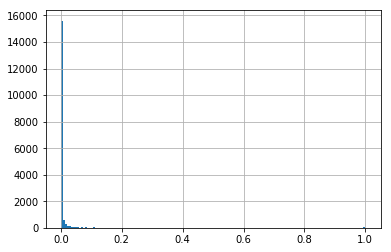

In [40]:
state = torch.load("models/resnet_34_finding_best_val.pt4")
model.load_state_dict(state, strict=True)
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
preds = hm.predict_on_test(valid_loader, model_dst)

index = preds.index.tolist()
indexes = [int(idx) for idx in index]
preds["abs_diff"] = np.abs(preds[0] - indexes)
preds["abs_diff"].hist(bins=150)

In [41]:
preds['names'] = X_val
del_from_validation = set(np.array(preds["names"][preds["abs_diff"] < thresh]))
mask = np.array([True if item in del_from_validation else False for item in X_val])
X_good, X_bad, y_good, y_bad = X_val[np.invert(mask)], X_val[mask], y_val[np.invert(mask)], y_val[mask]
X_train_new, y_train_new = np.concatenate((X_train, X_bad)), np.concatenate((y_train, y_bad))
X_white_list, y_white_list = X_good, y_good

In [44]:
6593/42815

0.15398808828681537

In [46]:
np.save("IDRnD/data/four_cicle_loop_validation", np.array([X_train_new, y_train_new, X_white_list, y_white_list]))